In [43]:
reset -sf

In [44]:
%pylab inline

import pandas as pd
import seaborn as sns
import numpy as np

import statsmodels as sm
import statsmodels.api as sms
from statsmodels.formula.api import ols

from sklearn.cluster import KMeans
from sqlalchemy import create_engine

Populating the interactive namespace from numpy and matplotlib


### 1. Load data set & clean data to analyze

In [45]:
#read Dow Jones Index data set from UCI web page
Dow_Jones_df = pd.read_csv('dow_jones_index.data')

In [46]:
new_col = []

#make sure there is '.', space or upper letter in columns 
for i in Dow_Jones_df.columns:
    new_col.append(i.replace(' ', '', len(i)).replace('.', '', len(i)).lower())
Dow_Jones_df.columns = new_col
Dow_Jones_df.columns

Index(['quarter', 'stock', 'date', 'open', 'high', 'low', 'close', 'volume',
       'percent_change_price', 'percent_change_volume_over_last_wk',
       'previous_weeks_volume', 'next_weeks_open', 'next_weeks_close',
       'percent_change_next_weeks_price', 'days_to_next_dividend',
       'percent_return_next_dividend'],
      dtype='object')

In [47]:
#eliminate '$' sign from columns
Dow_Jones_df['open'] = Dow_Jones_df['open'].map(lambda x:x.lstrip('$'))
Dow_Jones_df['high'] = Dow_Jones_df['high'].map(lambda x:x.lstrip('$'))
Dow_Jones_df['low'] = Dow_Jones_df['low'].map(lambda x:x.lstrip('$'))
Dow_Jones_df['close'] = Dow_Jones_df['close'].map(lambda x:x.lstrip('$'))
Dow_Jones_df['next_weeks_open'] = Dow_Jones_df['next_weeks_open'].map(lambda x:x.lstrip('$'))
Dow_Jones_df['next_weeks_close'] = Dow_Jones_df['next_weeks_close'].map(lambda x:x.lstrip('$'))

In [48]:
Dow_Jones_df.shape

(750, 16)

In [49]:
#add columns for weekly_price mean and standard deviation
weekly_price = Dow_Jones_df[['open', 'high', 'low', 'close']].astype(float)
Dow_Jones_df.insert(7, 'weekly_price_mean', weekly_price.apply(lambda x: np.mean(x), axis=1))
Dow_Jones_df.insert(8, 'weekly_price_std', weekly_price.apply(lambda x: np.sqrt(var(x)), axis=1))
Dow_Jones_df.insert(9, 'up', Dow_Jones_df['percent_change_price'].apply(lambda x: 1 if x>0 else 0))

Adding dividend profit to each company for half year (The first 2 qurater in 2011).
<br>
Each companies have a different amount of return and a diffrent number of times return for dividend  in the first 2 quater, so I need to add into average price of stock.
>Dividend_profit (div_profit) = div_mean_per  X  price_mean_first_two  X  num_dividend
<br>
<br>
>$Dividned~ Each~ Week = \dfrac{Dividend~ Profit}{Number~ of~ Weeks}$

In [50]:
#mean of dividend profit for each stock
div_mean_per = Dow_Jones_df.groupby(['stock']).percent_return_next_dividend.mean()

#mean of stock price for the first two quarter
price_mean_first_two = Dow_Jones_df.groupby(['stock']).weekly_price_mean.mean()

#check number of times for expeced dividend 
num_dividend = Dow_Jones_df[Dow_Jones_df['days_to_next_dividend'] <= 5].groupby(['stock']).date.count()

#profit of dividend return for the first two quarter (since the unit is cent, convert into dollar; X 1/100)
div_profit = div_mean_per * price_mean_first_two * num_dividend * 1/100

#number of weeks for the first two quarter
num_weeks = Dow_Jones_df.groupby(['stock']).date.count()

#calculate dividend return for each week
div_profit_each_week = pd.DataFrame(div_profit/num_weeks, index=Dow_Jones_df['stock'])

In [51]:
#add new column for dividend profit
Dow_Jones_df.insert(9, 'div_profit', div_profit_each_week.values)

#DIS stock is not available for dividend, so if the column of div_profit nan, it convert to zero.
Dow_Jones_df['div_profit'] = Dow_Jones_df['div_profit'].fillna(0)

In [52]:
#count week number from date. The total number of weeks for the first two quarter is 25.
Dow_Jones_df['date'] = pd.to_datetime(Dow_Jones_df['date'])
Dow_Jones_df.insert(3, 'week', Dow_Jones_df['date'].apply(lambda x: x.week))

#add the column which is weekly means price + expected dividend profit for each week
Dow_Jones_df.insert(9, 'price_mean_add_div_profit', Dow_Jones_df['weekly_price_mean']+Dow_Jones_df['div_profit'])

In [53]:
#clean data groupby stocks in order to classify stock
half_year_df = Dow_Jones_df.groupby(['stock']).weekly_price_mean.std().reset_index()
half_year_df['half_year_mean'] = Dow_Jones_df.groupby(['stock']).weekly_price_mean.mean().values
half_year_df = half_year_df.rename(columns={'weekly_price_mean':'half_year_std'})

### 2. Clustering

Decoposition with SVD

In [54]:
#SVD for standard deviation and mean price to make into risk_group and less_risk_group
kmean_list_svd = half_year_df[['half_year_std', 'half_year_mean']]
k_u, k_si, k_v  = np.linalg.svd(kmean_list_svd.T)
print('Kmean_U\n', k_u)
print('\nKmean_si\n', k_si)
print('\nKmean_V\n', np.round(k_v,3))

Kmean_U
 [[-0.04095693 -0.99916091]
 [-0.99916091  0.04095693]]

Kmean_si
 [ 344.11957825    4.16425378]

Kmean_V
 [[-0.048 -0.136 -0.213 -0.038 -0.3   -0.053 -0.294 -0.153 -0.12  -0.058
  -0.106 -0.121 -0.473 -0.062 -0.182 -0.129 -0.19  -0.094 -0.225 -0.266
  -0.1   -0.076 -0.058 -0.186 -0.086 -0.172 -0.244 -0.106 -0.157 -0.238]
 [-0.009 -0.105 -0.009 -0.194 -0.429 -0.283 -0.246 -0.029 -0.015 -0.012
   0.074 -0.563  0.165 -0.039 -0.049 -0.015  0.205 -0.04   0.074  0.285
  -0.052 -0.067 -0.032  0.227 -0.033 -0.037  0.133  0.14   0.191  0.068]
 [-0.215  0.018  0.955 -0.01  -0.068 -0.014 -0.065 -0.033 -0.025 -0.012
  -0.021 -0.032 -0.097 -0.014 -0.039 -0.027 -0.037 -0.02  -0.046 -0.052
  -0.022 -0.017 -0.012 -0.036 -0.018 -0.037 -0.05  -0.021 -0.031 -0.049]
 [-0.064 -0.186 -0.004  0.965 -0.079 -0.051 -0.047 -0.007 -0.004 -0.003
   0.012 -0.101  0.023 -0.008 -0.011 -0.004  0.034 -0.008  0.01   0.047
  -0.01  -0.013 -0.006  0.038 -0.007 -0.009  0.02   0.023  0.032  0.009]
 [-0.358 -0.384 -

In [55]:
#using K-mean algorithm to classify two groups
cluster_stock = KMeans(n_clusters=2, random_state=0).fit(k_v)

In [56]:
half_year_df['group'] = cluster_stock.labels_
cluster_stock.labels_

array([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int32)

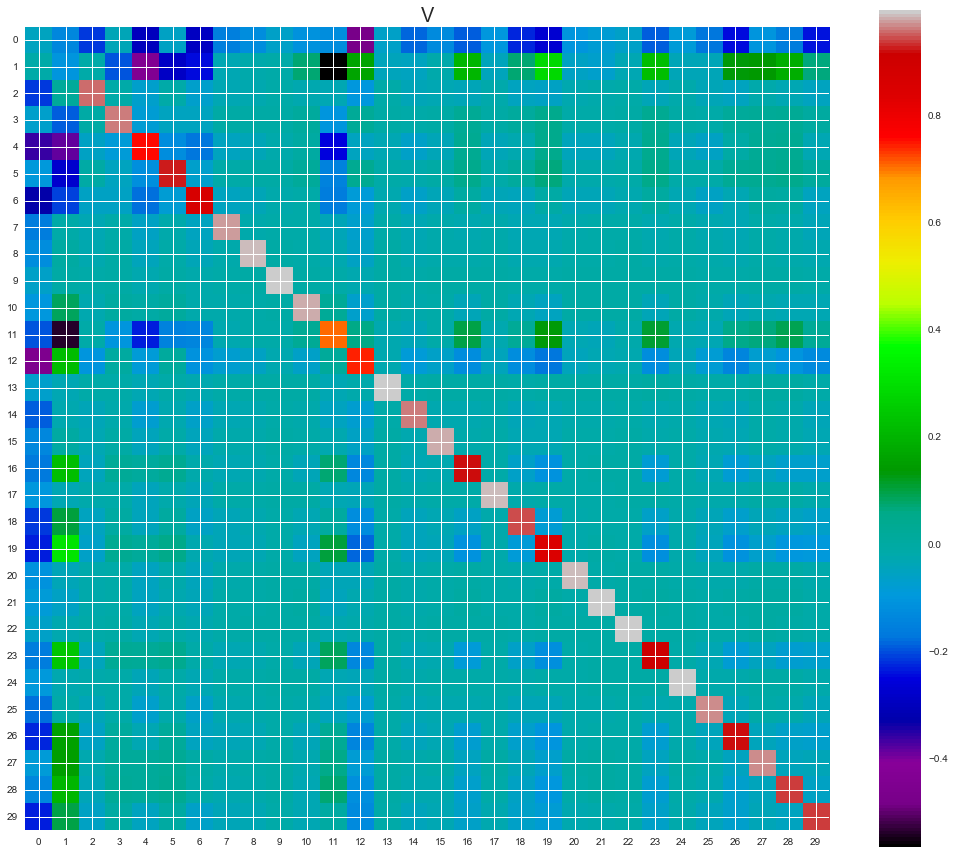

In [57]:
#plotting two groups
'''
Since the first sigma(eigenvalue) value is an important, 
so the first row of V(future) is the important to seperate groups.
similar color is in the same groups.
'''
plt.figure(figsize=(18,15))

plt.imshow(k_v, interpolation='nearest').set_cmap('spectral')
plt.xticks(range(len(kmean_list_svd.values)))
plt.yticks(range(len(kmean_list_svd.index.values)))
ax = plt.gca()

plt.title('V',fontsize=20)
plt.colorbar();

In [82]:
'''
Eigenvalue σ1 in sigma about an order of magnitude greater than σ2, 
indicating that the values in the first rows of V are much more important than the values in the second row. 
In fact I could closely reproduce A using just the first rows of V and first columns of U.

The first column of U, σ1 of sigma, row of V are important future values for clustering,
so multiply those values and compare with actual values in order to see error.
'''
stock_appx = np.matrix(k_u[:, :1]) * np.diag(k_si[:1]) * np.matrix(k_v[:1, :])
svd_result = pd.DataFrame(stock_appx.T, index=half_year_df['stock'].values, columns=kmean_list_svd.columns)
print ('A calculated using only the first one component:\n', 'Shape:', svd_result.shape, '\n') 
svd_result.head(10).T

A calculated using only the first one component:
 Shape: (30, 2) 



,AA,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE
half_year_std,0.677926,1.910588,3.004312,0.538954,4.222465,0.740581,4.140418,2.160485,1.688842,0.811803
half_year_mean,16.538287,46.609555,73.291405,13.147994,103.008733,18.066769,101.007161,52.705898,41.199982,19.804257


In [84]:
#subtract actual values and expected value from multiplication = error
'''
Although the error of standard deviation for some stocks(mostly in more risk group) are large number of difference, 
the error for mean in all stocks is less than 1%, 
so I can say that stock_appx (first rows of orthonormal eigenvector in V and first columns of orthonormal eigenvector U)
can reproduce A 99%.  
'''
error = (kmean_list_svd.set_index(half_year_df['stock']) - svd_result)
print('\nError from actual value:\n', 'Shape:', error.shape, '\n')
error.head(10).T


Error from actual value:
 Shape: (30, 2) 



stock,AA,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE
half_year_std,0.036279,0.438026,0.036707,0.807341,1.786553,1.177539,1.023651,0.119480,0.062990,0.050177
half_year_mean,-0.001487,-0.017955,-0.001505,-0.033094,-0.073233,-0.048269,-0.041961,-0.004898,-0.002582,-0.002057


As calculating average and standard deviation from all 30 companies, I can see the price flowing for Dow Jones Index in the first half year in 2011.

In [18]:
#To see price moving for Dow Jones market
price = Dow_Jones_df[['week', 'weekly_price_mean']]
price = price.groupby(['week']).weekly_price_mean.sum()

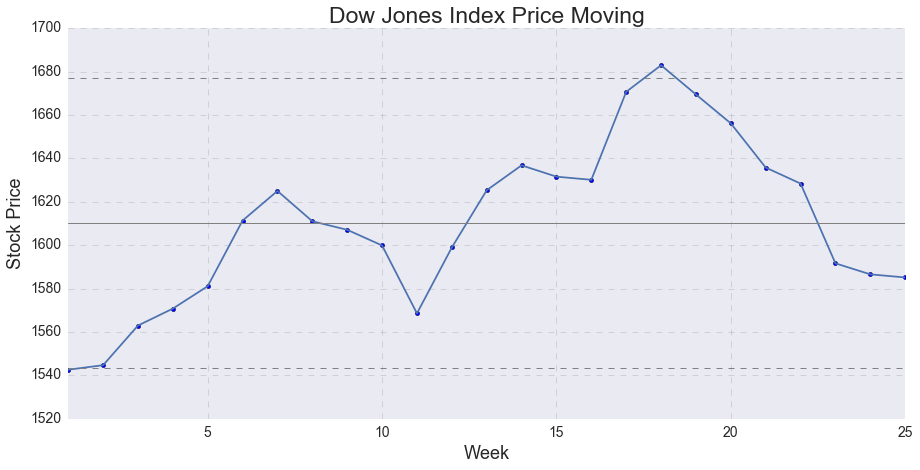

In [19]:
#make graph for price moving in Dow Jones Index
plt.figure(figsize=(15,7))
plt.scatter(price.index, price.values)
plt.plot(price.index, price.values)
plt.xlabel('Week', fontsize=18)
plt.ylabel('Stock Price', fontsize=18)
plt.title('Dow Jones Index Price Moving', fontsize=23)

plt.grid(axis='x', color='grey', linestyle='--', lw=0.5, alpha=0.5)
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)

plt.xlim(1, 25)
plt.tick_params(axis='both', labelsize=14)

plt.axhline(price.values.mean(), color='grey',linewidth = 1)
plt.axhline(1.8*np.std(price) + price.mean(), color='grey', linestyle='--', linewidth=1)
plt.axhline(price.mean() - 1.8*np.std(price), color='grey', linestyle='--', linewidth=1);

From this graph, Dow Jones Index have been moved in std x 1.8
<br>
Therefore, I make the eqaution to check whether K-mean work well in to petition into less risk and more risk groups.

Calculate risk variance;
>$Risk~ Variance(\%) = \pm \dfrac{1.8~ X~ Standard~ Diviation}{Stock~ Price}~ X~100$
>>Risk Variance tells that '+' and '-' price movement from Mean Price.

In [20]:
#check the K-mean algorithm
#Dow Jones index move in range +/-1.8 * standard deviation which I can called 'Risk Varience'.
half_year_df['risk_var'] = 1.8*half_year_df['half_year_std']*100/half_year_df['half_year_mean']

### Group ########################################################################

In [23]:
#setup less risk group
group_less_risk = half_year_df[half_year_df['group']==0]
group_less_risk = group_less_risk.drop('group',axis=1)

#setup more risk group
group_more_risk = half_year_df[half_year_df['group']==1]
group_more_risk = group_more_risk.drop('group',axis=1)

In [24]:
group_less_risk.head(3)

,stock,half_year_std,half_year_mean,risk_var
0,AA,0.714205,16.5368,7.773989
2,BA,3.041019,73.2899,7.468744
6,CVX,5.164068,100.9652,9.206462


In [25]:
group_more_risk.head(3)

,stock,half_year_std,half_year_mean,risk_var
1,AXP,2.348613,46.5916,9.073533
3,BAC,1.346295,13.1149,18.477688
4,CAT,6.009018,102.9355,10.507776


In [26]:
stock1 = group_less_risk['stock'].values
stock2 = group_more_risk['stock'].values
stock1_risk_mean = group_less_risk['risk_var'].mean()
stock2_risk_mean = group_more_risk['risk_var'].mean()
print('=== Less Risk Stock ========================================================')
print(' Less Risk Stock:\n', stock1,'\n')
print(' Average of Price Moving Range(%):\n', '+/-', round(stock1_risk_mean,2), '%')
print('============================================================================\n')
print('=== More Risk Stock ========================================================')
print(' More Risk Stock:\n', stock2, '\n')
print(' Average of Price Moving Range(%):\n', '+/-', round(stock2_risk_mean,2), '%')
print('============================================================================')

=== Less Risk Stock ========================================================
 Less Risk Stock:
 ['AA' 'BA' 'CVX' 'DD' 'DIS' 'GE' 'HD' 'IBM' 'JNJ' 'JPM' 'KO' 'KRFT' 'MCD'
 'MMM' 'MRK' 'MSFT' 'PFE' 'PG' 'T' 'TRV' 'UTX' 'VZ' 'WMT' 'XOM'] 

 Average of Price Moving Range(%):
 +/- 7.09 %

=== More Risk Stock ========================================================
 More Risk Stock:
 ['AXP' 'BAC' 'CAT' 'CSCO' 'HPQ' 'INTC'] 

 Average of Price Moving Range(%):
 +/- 13.92 %


As comparing between risk variable and the result of K-mean clustering, K-mean is work well.

### OLS Predict

In [27]:
#organize data set in order to seperate group data sets
half_year_df['volume'] = Dow_Jones_df.groupby(['stock']).volume.mean().values
half_year_df['price_up'] = Dow_Jones_df.groupby(['stock']).up.sum().values

In [28]:
#check the model fit in order to know which variables effect to price
#The first, the column 'price_up' is not really effect to stock price.
#The second, the column 'group' is not really effect to stock price.
model = ols('half_year_mean~ half_year_std + risk_var + volume', data=half_year_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         half_year_mean   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     106.5
Date:                Fri, 14 Oct 2016   Prob (F-statistic):           1.01e-14
Time:                        20:22:23   Log-Likelihood:                -108.26
No. Observations:                  30   AIC:                             224.5
Df Residuals:                      26   BIC:                             230.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        39.5797      5.083      7.787      0.000      29.132      50.027
half_year_std    23.1665      1.592     14.554      0.000      19.895      26.438
risk_var         -5.2430      0.754     -6.958      0.000      -6.792      -3.694
volume         4.441e-08      2e-08      2.217      0.036    3.24e-09    8.56e-08
==============================================================================
Omnibus:                        1.373   Durbin-Watson:                   2.825
Prob(Omnibus):                  0.503   Jarque-Bera (JB):                0.467
Skew:                           0.222   Prob(JB):                        0.792
Kurtosis:                       3.420   Cond. No.                     5.50e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.5e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

>Since Adj. R-squared and p-value, this is a good model fit to predict stock price.
<br> 
However, I grouped based on the half_year_std and risk_var, so I will use two variables, half_year_std and risk_var,
in order to predict stock price.

In [29]:
X = half_year_df[['half_year_std', 'risk_var']]
X = sms.add_constant(X)
y = half_year_df['half_year_mean']

model_p = sms.OLS(y, X)
results_p = model_p.fit()
results_p.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         half_year_mean   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     137.3
Date:                Fri, 14 Oct 2016   Prob (F-statistic):           7.08e-15
Time:                        20:22:23   Log-Likelihood:                -110.86
No. Observations:                  30   AIC:                             227.7
Df Residuals:                      27   BIC:                             231.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            38.8714      5.428      7.161      0.000      27.734      50.009
half_year_std    21.0415      1.360     15.472      0.000      18.251      23.832
risk_var         -3.9647      0.519     -7.636      0.000      -5.030      -2.899
==============================================================================
Omnibus:                        3.815   Durbin-Watson:                   2.852
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                2.562
Skew:                           0.697   Prob(JB):                        0.278
Kurtosis:                       3.328   Cond. No.                         27.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

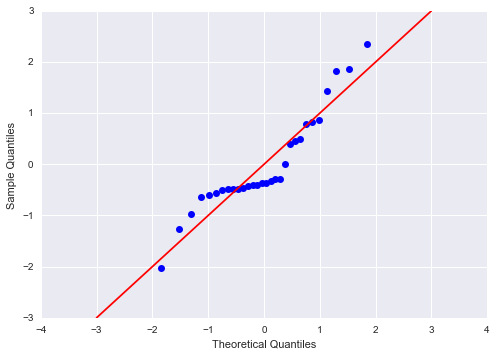

In [30]:
from statsmodels.graphics.gofplots import qqplot
# There are various ways of standardizing the residuals 
# Using the pearson residuals as the standardized residuals
#draw qqplot to test residual normality 
sres1 = results_p.resid_pearson
qqplot(sres1)
q = linspace(-3, 3)
plot(q, q, color='r');

>Based on the graphs, the residuals appear normality assumption is not met. Hence, model fails normality assumption.

In [31]:
#In order to improve normality, use log(y) instead of y
log_y = np.log(y)
model_log = sms.OLS(log_y, X)
results_log = model_log.fit()
results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         half_year_mean   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     114.5
Date:                Fri, 14 Oct 2016   Prob (F-statistic):           6.47e-14
Time:                        20:22:24   Log-Likelihood:                 5.8387
No. Observations:                  30   AIC:                            -5.677
Df Residuals:                      27   BIC:                            -1.474
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.7533      0.111     33.814      0.000       3.526       3.981
half_year_std     0.3671      0.028     13.200      0.000       0.310       0.424
risk_var         -0.0938      0.011     -8.837      0.000      -0.116      -0.072
==============================================================================
Omnibus:                        3.047   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.720
Skew:                          -0.699   Prob(JB):                        0.257
Kurtosis:                       2.526   Cond. No.                         27.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

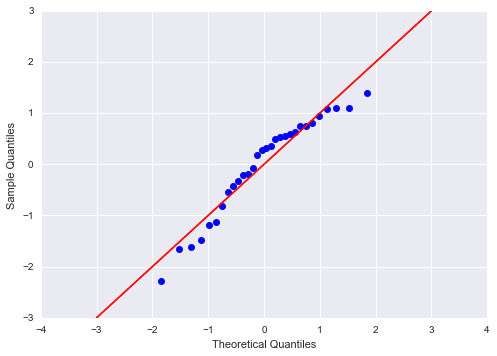

In [32]:
#plotting qqplot, normality is improve
sres2 = results_log.resid_pearson
qqplot(sres2)
q = linspace(-3, 3)
plot(q, q, color='r');

In [33]:
stock1_std_mean = group_less_risk['half_year_std'].mean()
stock2_std_mean = group_more_risk['half_year_std'].mean()
print('=== Less Risk Stock ============================================')
print(' Stock Std Mean:', stock1_std_mean)
print(' Price Moving Range(%):', stock1_risk_mean)
print('\n=== More Risk Stock ============================================')
print(' Stock Std Mean:', stock2_std_mean)
print(' Price Moving Range(%):', stock2_risk_mean)

=== Less Risk Stock ============================================
 Stock Std Mean: 2.1741172118192837
 Price Moving Range(%): 7.090034408117393

=== More Risk Stock ============================================
 Stock Std Mean: 2.786547629045008
 Price Moving Range(%): 13.91662840077642


In [34]:
#In order to predict, using result_log which values is improved model for normality
#add constant columns to use log regression
group_less_risk_prid = group_less_risk.drop(['stock', 'half_year_mean'], axis=1)
group_less_risk_prid = sms.add_constant(group_less_risk_prid)
group_more_risk_prid = group_more_risk.drop(['stock', 'half_year_mean'], axis=1)
group_more_risk_prid = sms.add_constant(group_more_risk_prid)

In [35]:
#predict the price for two different group in each stock
#Since y values (predicted stock price) is log value, it need to convert to price values from log values with exp()
less_predict = results_log.predict(group_less_risk_prid)
more_predict = results_log.predict(group_more_risk_prid)
less_predict = np.round(exp(less_predict), 2)
more_predict = np.round(exp(more_predict), 2)

In [36]:
#Less risk group's price
predict_one = pd.DataFrame(index=group_less_risk['stock'].values)
cur_price_one = np.round(group_less_risk['half_year_mean'].values, 2)
predict_one['Current Price'] = cur_price_one
predict_one['Predict Price'] = less_predict.values
per_change_one = np.round((less_predict - cur_price_one)*100 / cur_price_one, 2)
predict_one['Percent Change(%)'] = per_change_one.values
print('Average Percentage Change(%):', np.round(per_change_one.mean(), 2))
predict_one.head(18).T

Average Percentage Change(%): 1.69


,AA,BA,CVX,DD,DIS,GE,HD,IBM,JNJ,JPM,KO,KRFT,MCD,MMM,MRK,MSFT,PFE,PG
Current Price,16.54,73.29,100.97,52.70,41.20,19.80,36.57,162.63,62.57,44.51,65.33,32.36,77.23,91.63,34.39,26.07,19.78,63.91
Predict Price,26.74,64.64,119.73,47.45,39.58,28.07,38.12,205.77,55.83,41.68,52.00,33.86,65.17,68.23,34.87,29.21,26.96,50.66
Percent Change(%),61.67,-11.80,18.58,-9.96,-3.93,41.77,4.24,26.53,-10.77,-6.36,-20.40,4.64,-15.62,-25.54,1.40,12.04,36.30,-20.73


In [37]:
#More risk group's price
predict_two = pd.DataFrame(index=group_more_risk['stock'].values)
cur_price_two = np.round(group_more_risk['half_year_mean'].values, 2)
predict_two['Current Price'] = cur_price_two
predict_two['Predict Price'] = more_predict.values
per_change_two = np.round((more_predict - cur_price_two)*100 / cur_price_two, 2)
predict_two['Percent Change(%)'] = per_change_two.values
print('Average Percentage Change(%):', np.round(per_change_two.mean(), 2))
predict_two.T

Average Percentage Change(%): 3.72


,AXP,BAC,CAT,CSCO,HPQ,INTC
Current Price,46.59,13.11,102.94,18.02,41.63,21.47
Predict Price,43.13,12.35,144.50,14.29,36.48,27.53
Percent Change(%),-7.43,-5.80,40.37,-20.70,-12.37,28.23
